---
---
### Deep Learning Practice (series 1)
##### Mostafa Shahbazi Dill - id: 40252521602
##### 2024-March-01
---
---

#### Importing Required Libraries

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import madgrad
import matplotlib.pyplot as plt

---
---
### 1. Dataset Details

In [62]:
# Define transform to convert images to tensors
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Compute the number of input nodes
input_nodes = 28 * 28  # MNIST images are 28x28 pixels

# Compute the number of output nodes
output_nodes = 10  # Since there are 10 classes (digits 0-9)

---
### 1.1
##### MLP model with two hidden layers

In [47]:
class MLP(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # x = torch.relu(self.fc1(x)) # default activation function
        x = self.activation(self.fc1(x))
        x = self.dropout(x)

        # x = torch.relu(self.fc2(x)) # default activation function
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

---
### 1.2
##### training loop and evaluation function

In [48]:
def train(model, criterion, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    # print(f"Accuracy on test set: {accuracy}")
    return accuracy

---
---
#### 2.1
##### optimization methods: SGD, Adam, RMSprop, MADGRAD (paper), mirrorMADGRAD (paper)

In [49]:
# Define the model, loss function, and optimization methods
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
criterion = nn.CrossEntropyLoss()

# Train with SGD optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
train(model, criterion, optimizer_sgd, train_loader, epochs=5)
accuracy_sgd = evaluate(model, test_loader)

# Train with Adam optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
train(model, criterion, optimizer_adam, train_loader, epochs=5)
accuracy_adam = evaluate(model, test_loader)

# Train with RMSprop optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)
train(model, criterion, optimizer_rmsprop, train_loader, epochs=5)
accuracy_rmsprop = evaluate(model, test_loader)

# Train with MADGRAD optimizer (our new optimizer according to the paper)
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_madgrad = madgrad.MADGRAD(
    params=model.parameters(), decouple_decay=True, lr=0.001
)
train(model, criterion, optimizer_madgrad, train_loader, epochs=5)
accuracy_madgrad = evaluate(model, test_loader)

# Train with MirrorMADGRAD optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_mirrormadgrad = madgrad.MirrorMADGRAD(
    params=model.parameters(), decouple_decay=True, lr=0.001
)
train(model, criterion, optimizer_mirrormadgrad, train_loader, epochs=5)
accuracy_mirrormadgrad = evaluate(model, test_loader)


print(f">>(SGD)<<Accuracy: {accuracy_sgd}")
print(f">>(Adam)<<Accuracy: {accuracy_adam}")
print(f">>(RMSprop)<<Accuracy: {accuracy_rmsprop}")
print(f">>(MADGRAD - paper op)<<Accuracy: {accuracy_madgrad}")
print(f">>(MirrorMADGRAD - paper op)<<Accuracy: {accuracy_mirrormadgrad}")

>>(SGD)<<Accuracy: 0.9226
>>(Adam)<<Accuracy: 0.9361
>>(RMSprop)<<Accuracy: 0.9311
>>(MADGRAD - paper op)<<Accuracy: 0.9306
>>(MirrorMADGRAD - paper op)<<Accuracy: 0.9434


---
---
### 3.1
##### evaluate with different activation functions

##### activation functions: ReLU, Sigmoid, Softmax

In [64]:
# Define activation functions
activations = [torch.relu, torch.sigmoid, torch.tanh]

# Evaluate the model with different activation functions
for activation in activations:
    model = MLP(
        input_nodes, 128, 64, output_nodes, dropout_rate=0.5, activation=activation
    )

    optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_loader, epochs=5)
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with activation {activation.__name__}: {accuracy}")

print(f"\nOptimizer: {optimizer.__class__.__name__}")

Accuracy with activation relu: 0.9404
Accuracy with activation sigmoid: 0.9458
Accuracy with activation tanh: 0.9402

Optimizer: Adam


---
---
## 4.1
#### Dropout rates: 0.1, 0.3, 0.5, 0.7, 0.9

In [51]:
dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
for dropout_rate in dropout_rates:
    model = MLP(
        input_size=input_nodes,
        hidden_size1=128,
        hidden_size2=64,
        output_size=output_nodes,
        dropout_rate=dropout_rate,
        activation=torch.sigmoid,
    )

    optimizer = madgrad.MADGRAD(params=model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_loader, epochs=5)
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with dropout rate {dropout_rate}: {accuracy}")

print(f"\nOptimizer: {optimizer.__class__.__name__}")

Accuracy with dropout rate 0.1: 0.9643
Accuracy with dropout rate 0.3: 0.962
Accuracy with dropout rate 0.5: 0.9438
Accuracy with dropout rate 0.7: 0.9114
Accuracy with dropout rate 0.9: 0.534

Optimizer: MADGRAD


---
---
### 5.1
#### Data Augmentation

In [52]:
# Augmentation transforms
augmentation_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Augmented dataset
augmented_train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=augmentation_transform, download=True
)
augmented_train_loader = DataLoader(
    augmented_train_dataset, batch_size=64, shuffle=True
)

# Evaluate the model with augmented data
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.1,
    activation=torch.sigmoid,
)
optimizer = madgrad.MirrorMADGRAD(params=model.parameters(), lr=0.001)
# optimizer = optim.Adam(params=model.parameters(), lr=0.001)
train(model, criterion, optimizer, augmented_train_loader, epochs=5)
accuracy_augmented = evaluate(model, test_loader)
print(f"Accuracy with data augmentation: {accuracy_augmented}")

Accuracy with data augmentation: 0.8302


## 6.1
#### Batch Normalization

In [53]:
def train_plt(model, criterion, optimizer, train_loader, epochs, batch_size):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        # for i, (inputs, labels) in enumerate(train_loader, 1):
        #     optimizer.zero_grad()
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
        #     running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
        #     if i % 100 == 0:
        #         print(
        #             f"Epoch {epoch+1}, Batch {i}, Loss: {running_loss/(i*batch_size)}"
        #         )

        for i, data in enumerate(train_loader, 0):

            # Get inputs
            inputs, targets = data

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 0:
                print("Loss after mini-batch %5d: %.3f" % (i + 1, running_loss / 100))
                running_loss = 0.0

        epoch_loss = running_loss / len(
            train_loader.dataset
        )  # Divide by total number of samples
        losses.append(epoch_loss)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss ,batch size: {batch_size}")
    plt.show()


class MlpBatch(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MlpBatch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # x = torch.relu(self.fc1(x)) # default activation function
        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        # x = torch.relu(self.fc2(x)) # default activation function
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

### batch normalization before activation function
### batch sizes: 16, 128


Training with batch size: 16
Loss after mini-batch     1: 0.027
Loss after mini-batch   101: 0.867
Loss after mini-batch   201: 0.551
Loss after mini-batch   301: 0.486
Loss after mini-batch   401: 0.512
Loss after mini-batch   501: 0.458
Loss after mini-batch   601: 0.397
Loss after mini-batch   701: 0.426
Loss after mini-batch   801: 0.402
Loss after mini-batch   901: 0.347
Loss after mini-batch  1001: 0.349
Loss after mini-batch  1101: 0.365
Loss after mini-batch  1201: 0.362
Loss after mini-batch  1301: 0.373
Loss after mini-batch  1401: 0.324
Loss after mini-batch  1501: 0.343
Loss after mini-batch  1601: 0.324
Loss after mini-batch  1701: 0.315
Loss after mini-batch  1801: 0.296
Loss after mini-batch  1901: 0.312
Loss after mini-batch  2001: 0.290
Loss after mini-batch  2101: 0.272
Loss after mini-batch  2201: 0.272
Loss after mini-batch  2301: 0.308
Loss after mini-batch  2401: 0.288
Loss after mini-batch  2501: 0.307
Loss after mini-batch  2601: 0.306
Loss after mini-batch  27

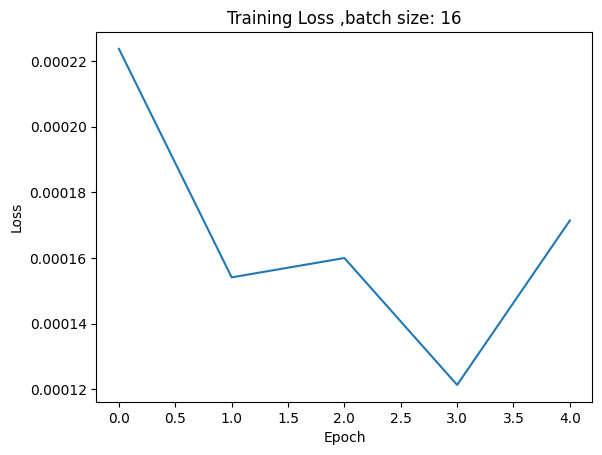

Accuracy with batch size 16: 0.9596

Training with batch size: 128
Loss after mini-batch     1: 0.023
Loss after mini-batch   101: 0.552
Loss after mini-batch   201: 0.323
Loss after mini-batch   301: 0.235
Loss after mini-batch   401: 0.193
Loss after mini-batch     1: 0.001
Loss after mini-batch   101: 0.147
Loss after mini-batch   201: 0.151
Loss after mini-batch   301: 0.139
Loss after mini-batch   401: 0.130
Loss after mini-batch     1: 0.001
Loss after mini-batch   101: 0.103
Loss after mini-batch   201: 0.106
Loss after mini-batch   301: 0.100
Loss after mini-batch   401: 0.109
Loss after mini-batch     1: 0.001
Loss after mini-batch   101: 0.082
Loss after mini-batch   201: 0.087
Loss after mini-batch   301: 0.087
Loss after mini-batch   401: 0.096
Loss after mini-batch     1: 0.000
Loss after mini-batch   101: 0.068
Loss after mini-batch   201: 0.071
Loss after mini-batch   301: 0.077
Loss after mini-batch   401: 0.081


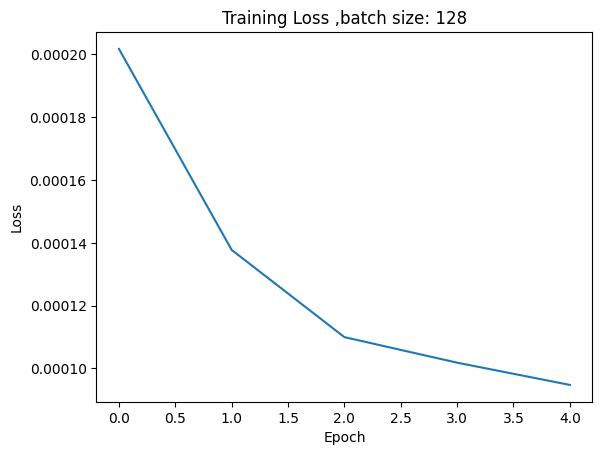

Accuracy with batch size 128: 0.9636


In [54]:
# Define batch sizes to test
batch_sizes = [16, 128]
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    batch_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = MlpBatch(
        input_size=input_nodes,
        hidden_size1=128,
        hidden_size2=64,
        output_size=output_nodes,
        dropout_rate=0.1,
        activation=torch.sigmoid,
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # train(model, criterion, optimizer, train_loader, epochs=5)
    train_plt(
        model, criterion, optimizer, batch_train_loader, epochs=5, batch_size=batch_size
    )
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with batch size {batch_size}: {accuracy}")

----
----
### 7.1 : Refactor Models
### increase the number of hidden layers to 4 layers
#### dropout rate: 0.1, activation function: sigmoid, optimizer: Adam

In [61]:
class MlpBatch4L(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        hidden_size4,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MlpBatch4L, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # layer 1
        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        # layer 2
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        # layer 3
        x = self.activation(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        # layer 4
        x = self.activation(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        # output layer
        x = self.fc5(x)

        return x


class MLP4L(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        hidden_size4,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MLP4L, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # layer 1
        x = self.activation(self.fc1(x))
        x = self.dropout(x)

        # layer 2
        x = self.activation(self.fc2(x))
        x = self.dropout(x)

        # layer 3
        x = self.activation(self.fc3(x))
        x = self.dropout(x)

        # layer 4
        x = self.activation(self.fc4(x))
        x = self.dropout(x)

        # output layer
        x = self.fc5(x)

        return x

### 7.2
#### model with 4 hidden layers and batch normalization

In [60]:
batch_train_loader_ = DataLoader(train_dataset, batch_size=128, shuffle=True)
model = MlpBatch4L(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    hidden_size3=32,
    hidden_size4=16,
    output_size=output_nodes,
    dropout_rate=0.1,
    activation=torch.sigmoid,
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, criterion, optimizer, train_loader, epochs=5)
# train_plt(
#     model, criterion, optimizer, batch_train_loader, epochs=5, batch_size=batch_size
# )
accuracy = evaluate(model, test_loader)
print(f"Accuracy with batch size {batch_size}: {accuracy}")

Accuracy with batch size 128: 0.9665


### 7.3
#### model with 4 hidden layers and without batch normalization

In [63]:
model = MLP4L(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    hidden_size3=32,
    hidden_size4=16,
    output_size=output_nodes,
    dropout_rate=0.1,
    activation=torch.sigmoid,
)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)
train(model, criterion, optimizer, train_loader, epochs=5)
accuracy = evaluate(model, test_loader)
print(f"Accuracy without batch Normalization: {accuracy}")

Accuracy without batch Normalization: 0.9242
